- Prepare the data via cleaning, normalization, encoding categorical variables, etc.
- Generate and evaluate a working linear model
- Enhance your model results by trying different model and/or data enhancement techniques, building 3 models with different regularization and feature engineering techniques
- Evaluate your models using multiple performance metrics and explain your choice of model
- Draw direct inferences and conclusions from model results (describe how your model results can improve or provide a solution to the problem you have chosen)
- Use graphs and evidence from the data to prove your conclusions in a form that tells a story that helps the a non-technical person in the business



For this exercise, we will only look at properties with:
- 0-10 bedrooms

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy
import scipy.stats as ss
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
import statsmodels.stats.power as smsp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import scale
from patsy import dmatrices
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
df = pd.read_csv(url)

#df['year'] = pd.DatetimeIndex(df['date']).year
#df['age'] = df['year']-df['yr_built']
#df.loc[df['age']<0,'age'] = 0


df['basement'] = 0
df.loc[df['sqft_basement']>0,'basement'] = 1


df.where((df['bedrooms']<=10), inplace=True)

df.dropna(inplace=True)

df.drop(['id', 'date'], axis=1, inplace=True)
df.drop(['sqft_basement'], axis=1, inplace=True) #'yr_built', 'yr_renovated', 'year'

df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,0.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0,1.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,0.0


In [52]:
for i in ['price', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
          'zipcode', 'sqft_living15', 'sqft_lot15', 'basement']: #'age', 'sqft_basement', 'yr_renovated',
    df[i] = df[i].astype('int')

    
for j in ['zipcode']: #, 'waterfront', 'basement'
    df[j] = df[j].astype('category')  
    
    
df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,221900,3.0,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,538000,3.0,2.25,2570,7242,2.0,0,0,3,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,1
2,180000,2.0,1.00,770,10000,1.0,0,0,3,6,770,1933,0.0,98028,47.7379,-122.233,2720,8062,0


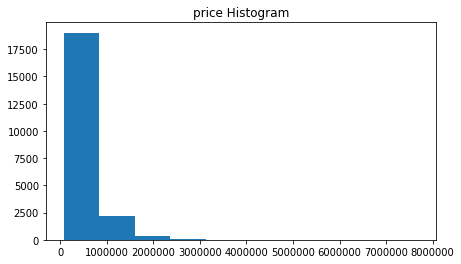

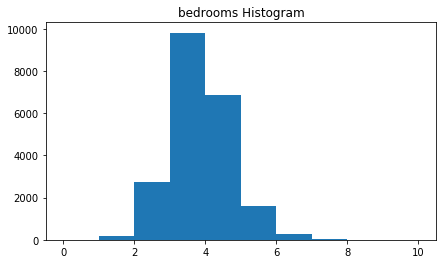

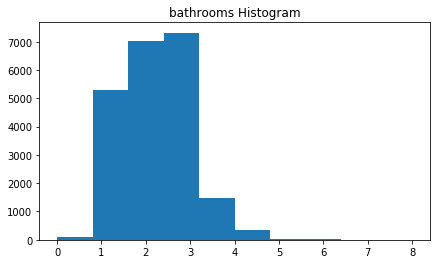

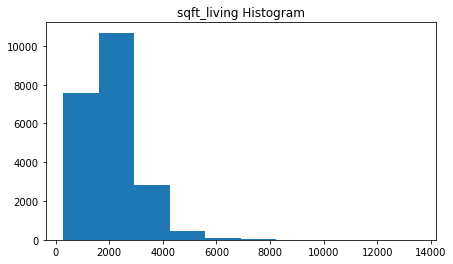

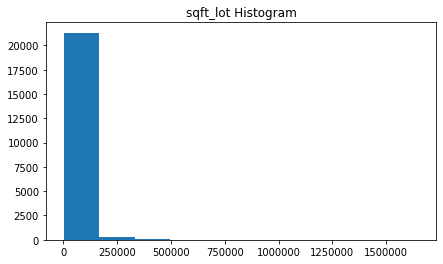

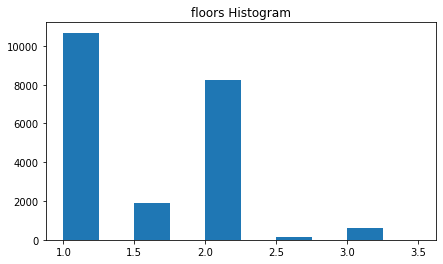

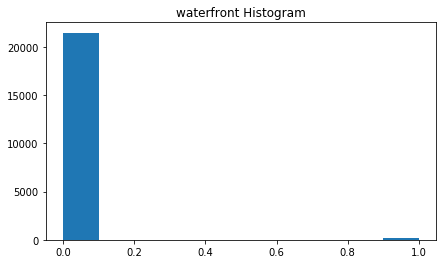

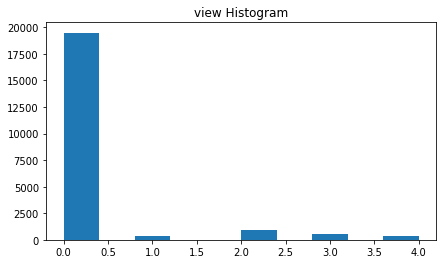

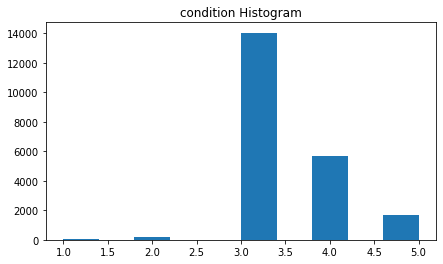

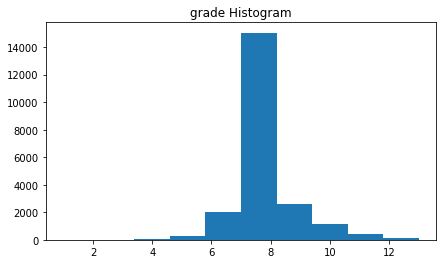

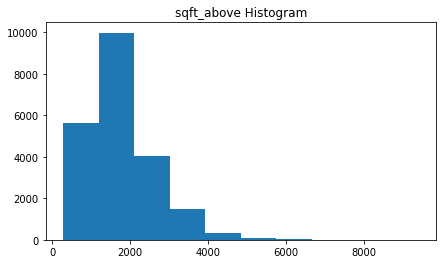

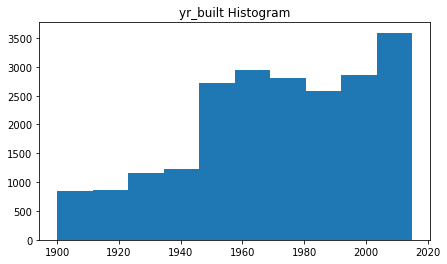

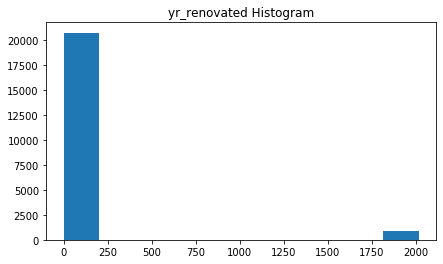

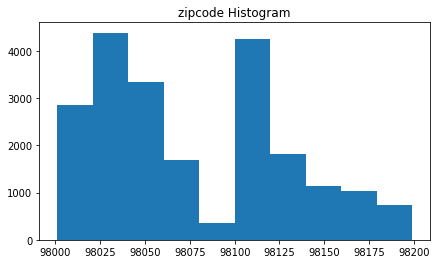

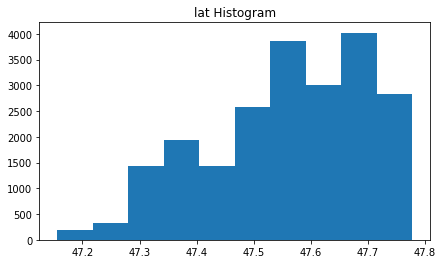

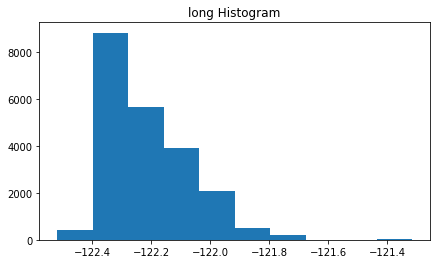

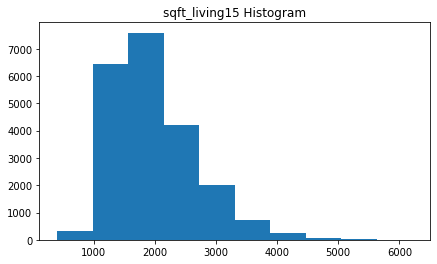

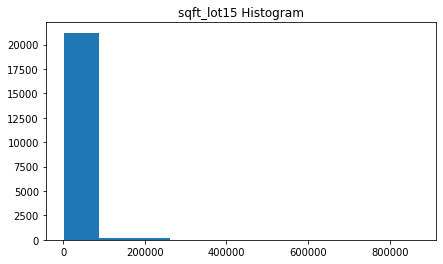

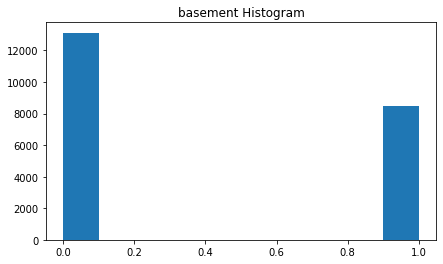

In [53]:
for i in df.columns:
    plt.figure(figsize=[7,4])
    plt.hist(df[i])
    plt.title(i+' Histogram')
    plt.show()

In [54]:
print('\nData types')
print(df.dtypes)

print('\nCheck for missing value')
print(df.isnull().any())

print('\nDataset shape: ')
print(df.shape)


Data types
price               int64
bedrooms          float64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
yr_built            int64
yr_renovated      float64
zipcode          category
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
basement            int64
dtype: object

Check for missing value
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
basement         False
dtype: bool

Datas

In [55]:
price_mean = np.mean(df['price'])
price_stdev = np.std(df['price'])

print('Price Mean :', np.round(price_mean,2))
print('Price Stdev :', np.round(price_stdev,2))

Price Mean : 540084.45
Price Stdev : 367135.04


In [56]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'basement'],
      dtype='object')

In [57]:
#one hot encoding categorical factors (waterfront, zipcode)

df2 = df.copy(deep=True)

#for j in ['waterfront']:
#    df_ohe = pd.get_dummies(df[j], prefix=j, columns=[j])
#    df2 = pd.concat([df2, df_ohe], axis=1)
#    df2.drop(columns = [j], inplace=True)


loglist = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for col in loglist:
    df2.loc[:, col+'_log'] = np.log(df2.loc[:,col])
    df2.drop([col], axis=1, inplace=True)


loglist2 = ['price_log', 'sqft_living_log', 'sqft_lot_log', 
            'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']
    
print(df2.head(3), '\n')

   bedrooms  bathrooms  floors  waterfront  view  condition  grade  yr_built  \
0       3.0       1.00     1.0           0     0          3      7      1955   
1       3.0       2.25     2.0           0     0          3      7      1951   
2       2.0       1.00     1.0           0     0          3      6      1933   

   yr_renovated zipcode      lat     long  basement  price_log  \
0           0.0   98178  47.5112 -122.257         0  12.309982   
1        1991.0   98125  47.7210 -122.319         1  13.195614   
2           0.0   98028  47.7379 -122.233         0  12.100712   

   sqft_living_log  sqft_lot_log  sqft_above_log  sqft_living15_log  \
0         7.073270      8.639411        7.073270           7.200425   
1         7.851661      8.887653        7.682482           7.432484   
2         6.646391      9.210340        6.646391           7.908387   

   sqft_lot15_log  
0        8.639411  
1        8.941022  
2        8.994917   



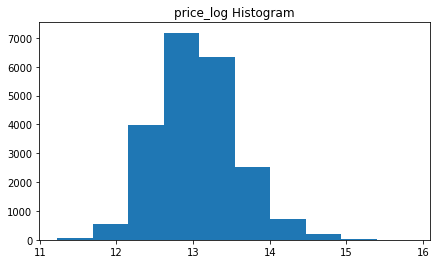

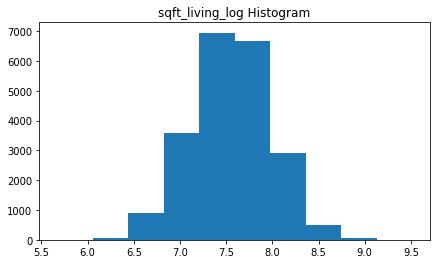

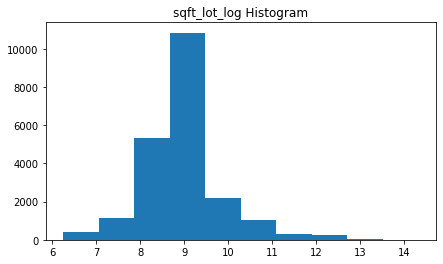

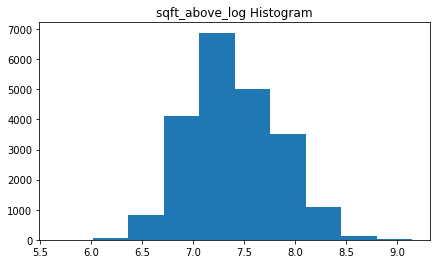

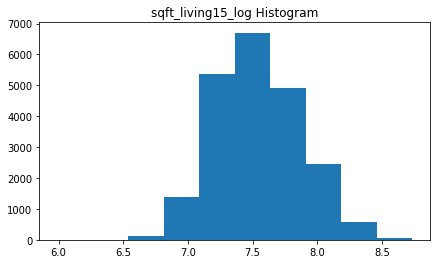

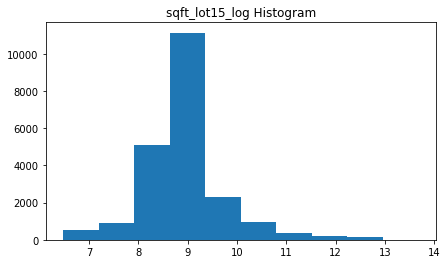

In [58]:
for i in loglist2:
    plt.figure(figsize=[7,4])
    plt.hist(df2[i])
    plt.title(i+' Histogram')
    plt.show()

In [59]:
df_scaled = df2.copy(deep=True)

df_scaled.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'basement', 'price_log', 'sqft_living_log', 'sqft_lot_log',
       'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

In [60]:
#scaling values

df_scaled = df2.copy(deep=True)

scalelist = df_scaled.drop(['price_log', 'zipcode'], axis=1).columns

for col in scalelist:
    df_scaled.loc[:,col] = scale(df2.loc[:,col])


df_scaled.head(3)

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,lat,long,basement,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_living15_log,sqft_lot15_log
0,-0.407191,-1.447417,-0.915420,-0.087177,-0.305775,-0.629167,-0.558870,-0.545043,-0.210018,98178,-0.352521,-0.306165,-0.804007,12.309982,-1.122992,-0.388482,-0.752092,-1.035225,-0.395567
1,-0.407191,0.175636,0.936501,-0.087177,-0.305775,-0.629167,-0.558870,-0.681230,4.749171,98125,1.161579,-0.746426,1.243771,13.195614,0.709363,-0.113403,0.672563,-0.326665,-0.024606
2,-1.510339,-1.447417,-0.915420,-0.087177,-0.305775,-0.629167,-1.409594,-1.294071,-0.210018,98028,1.283544,-0.135742,-0.804007,12.100712,-2.127877,0.244170,-1.750356,1.126439,0.041681


In [61]:
collist = df_scaled.columns.drop(['price_log'])

In [62]:
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()


def residual_plot(df, predicted_col, resids):
    RMSE = np.std(df[resids])
    plt.figure(figsize=[8,4])
    sns.scatterplot(x=predicted_col, y=resids, data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('Plot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()      

In [63]:
#formula

form1 = 'price_log ~ zipcode + bedrooms + bathrooms + floors + view + waterfront + condition + grade + yr_built + yr_renovated + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log'

form2 = 'price_log ~ zipcode + bedrooms + bathrooms + floors + view + waterfront + condition + grade + yr_built + yr_renovated + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log - 1'


In [64]:
#ols

df_scaled1 = df_scaled.copy(deep=True)

ols_model_1 = smf.ols(formula = form1,
                      data = df_scaled1).fit()

df_scaled1['predicted_price_ols'] = ols_model_1.predict(df_scaled1[collist])

print(ols_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1917.
Date:                Mon, 09 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:57:32   Log-Likelihood:                 6517.0
No. Observations:               21611   AIC:                        -1.286e+04
Df Residuals:                   21524   BIC:                        -1.217e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.6708      0.02

In [65]:
df_scaled1['price'] = np.exp(df_scaled1['price_log'])

df_scaled1['predicted_price_ols_unlogged'] = np.exp(df_scaled1['predicted_price_ols'])

df_scaled1['resids_ols'] = np.subtract(df_scaled1['predicted_price_ols_unlogged'], df_scaled1['price'])

df_scaled1[['price', 'predicted_price_ols_unlogged', 'resids_ols']].head()

,price,predicted_price_ols_unlogged,resids_ols
0,221900.0,234217.375121,12317.375121
1,538000.0,567221.902591,29221.902591
2,180000.0,258924.935495,78924.935495
3,604000.0,525495.404631,-78504.595369
4,510000.0,474504.299447,-35495.700553


Mean of predicted values = 530260.0
STD of predicted values = 327532.0



Text(0.5, 0, 'Price')

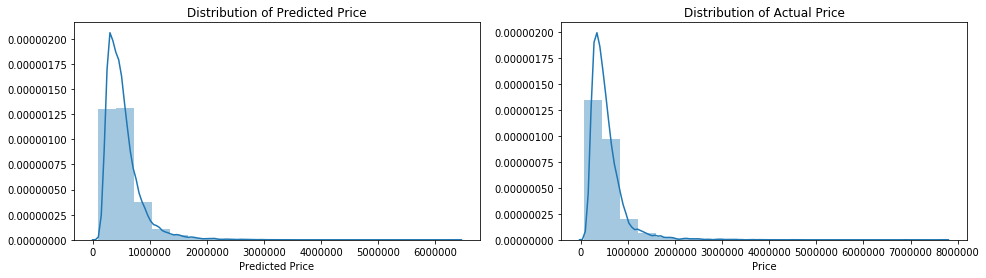

In [66]:
xmin = min(min(df_scaled1['predicted_price_ols_unlogged']), min(df_scaled1['price']))
xmax = max(max(df_scaled1['predicted_price_ols_unlogged']), max(df_scaled1['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled1['predicted_price_ols_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled1['predicted_price_ols_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled1['predicted_price_ols_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled1['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

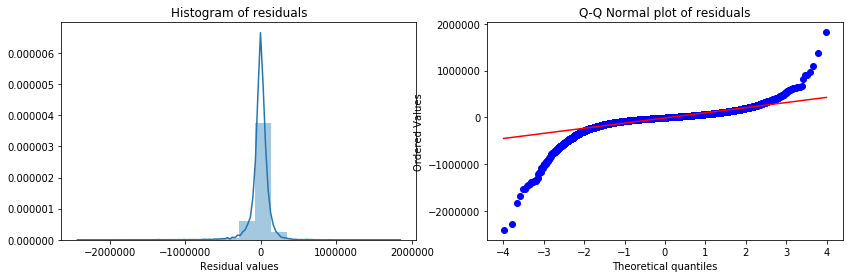

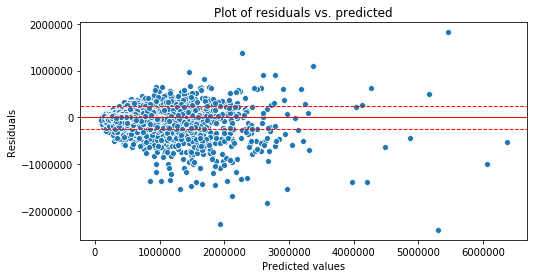

In [67]:
plot_resid_dist(df_scaled1['resids_ols'])

residual_plot(df_scaled1, 'predicted_price_ols_unlogged', 'resids_ols')

In [68]:
ssr1 = sum((df_scaled1['price_log']-df_scaled1['predicted_price_ols'])**2)       
sst1 = sum((df_scaled1['price_log']-np.mean(df_scaled1['price_log']))**2)    

r_squared1 = 1 - (float(ssr1))/sst1
adjusted_r_squared1 = 1 - (1-r_squared1)*(len(df_scaled1['price_log'])-1)/(len(df_scaled1['price_log'])-df_scaled1[collist].shape[1]-1)

rmse1 = round(np.sqrt(mean_squared_error(df_scaled1['price'], df_scaled1['predicted_price_ols_unlogged'])),2)

print('R-Squared: ', np.round(r_squared1,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared1,3))
print('RMSE: ', rmse1)

R-Squared:  0.885
Adj R-Squared:  0.884
RMSE:  126009.12


In [69]:
collist2 = collist.drop('zipcode')

print(collist2)

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'yr_built', 'yr_renovated', 'lat', 'long', 'basement',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')


In [70]:
#ridge regression

df_scaled2 = df_scaled.copy(deep=True)

y2, X2 = dmatrices(form2, data=df_scaled2)

for j in ['zipcode']:
    df_ohe = pd.get_dummies(df_scaled2[j], prefix=j, columns=[j])
    df_scaled2 = pd.concat([df_ohe, df_scaled2], axis=1)
    df_scaled2.drop(columns = [j], inplace=True)
        
ols_model_ridge = sm.OLS(y2, X2).fit_regularized(method = 'elastic_net', alpha=0.001, L1_wt=0.0)

In [71]:
#df_scaled2 = df_scaled.copy(deep=True)

#ols_model_ridge = smf.ols(form2, data=df_scaled2).fit_regularized(alpha=0.001,L1_wt=0.0)

df_scaled2['predicted_price_ridge'] = ols_model_ridge.predict(df_scaled2.drop(['price_log'], axis=1))

print(df_scaled2[['price_log', 'predicted_price_ridge']])

       price_log  predicted_price_ridge
0      12.309982              11.323038
1      13.195614              12.648820
2      12.100712              11.612879
3      13.311329              12.123765
4      13.142166              12.413293
...          ...                    ...
21608  12.793859              12.572835
21609  12.899220              11.916899
21610  12.904459              11.728972
21611  12.899220              12.019172
21612  12.691580              11.677316

[21611 rows x 2 columns]


In [72]:
df_scaled2['price'] = np.exp(df_scaled2['price_log'])

df_scaled2['predicted_price_ridge_unlogged'] = np.exp(df_scaled2['predicted_price_ridge'])

df_scaled2['resids_ridge'] = np.subtract(df_scaled2['predicted_price_ridge_unlogged'], df_scaled2['price'])

df_scaled2[['price', 'predicted_price_ridge_unlogged', 'resids_ridge']].head()

,price,predicted_price_ridge_unlogged,resids_ridge
0,221900.0,82705.226700,-139194.773300
1,538000.0,311395.733511,-226604.266489
2,180000.0,110511.957667,-69488.042333
3,604000.0,184197.657605,-419802.342395
4,510000.0,246050.675738,-263949.324262


Mean of predicted values = 244627.0
STD of predicted values = 170174.0



Text(0.5, 0, 'Price')

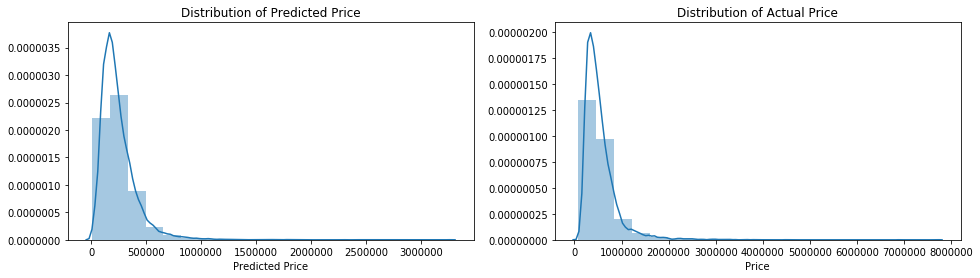

In [73]:
xmin = min(min(df_scaled2['predicted_price_ridge_unlogged']), min(df_scaled2['price']))
xmax = max(max(df_scaled2['predicted_price_ridge_unlogged']), max(df_scaled2['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled2['predicted_price_ridge_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled2['predicted_price_ridge_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled2['predicted_price_ridge_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled2['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

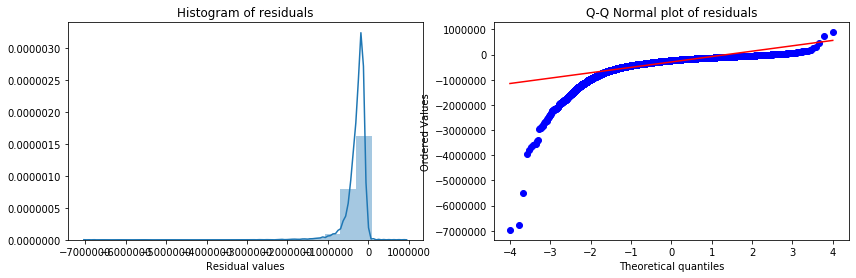

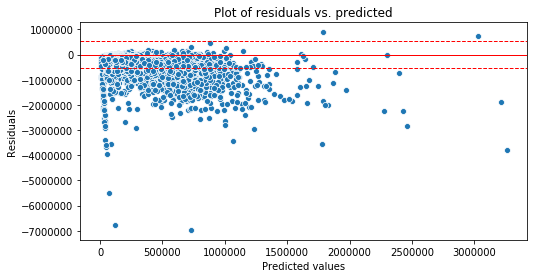

In [74]:
plot_resid_dist(df_scaled2['resids_ridge'])

residual_plot(df_scaled2, 'predicted_price_ridge_unlogged', 'resids_ridge')

In [75]:
ssr2 = sum((df_scaled2['price_log']-df_scaled2['predicted_price_ridge'])**2)       
sst2 = sum((df_scaled2['price_log']-np.mean(df_scaled2['price_log']))**2)    

r_squared2 = 1 - (float(ssr2))/sst2
adjusted_r_squared2 = 1 - (1-r_squared2)*(len(df_scaled2['price_log'])-1)/(len(df_scaled2['price_log'])-df_scaled2[collist2].shape[1]-1)

rmse2 = round(np.sqrt(mean_squared_error(df_scaled2['price'], df_scaled2['predicted_price_ridge_unlogged'])),2)

print('R-Squared: ', np.round(r_squared2,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared2,3))
print('RMSE: ', rmse2)

R-Squared:  -2.313
Adj R-Squared:  -2.316
RMSE:  395655.05


In [76]:
#ridge regression

df_scaled3 = df_scaled.copy(deep=True)

y3, X3 = dmatrices(form2, data=df_scaled3)

for j in ['zipcode']:
    df_ohe = pd.get_dummies(df_scaled3[j], prefix=j, columns=[j])
    df_scaled3 = pd.concat([df_ohe, df_scaled3], axis=1)
    df_scaled3.drop(columns = [j], inplace=True)
        
ols_model_lasso = sm.OLS(y3, X3).fit_regularized(method = 'elastic_net', alpha=0.001, L1_wt=1.0)

In [77]:
#df_scaled3 = df_scaled.copy(deep=True)

#ols_model_lasso = smf.ols(form2, data=df_scaled3).fit_regularized(alpha=0.001,L1_wt=1.0)

df_scaled3['predicted_price_lasso'] = ols_model_lasso.predict(df_scaled3.drop(['price_log'], axis=1))

print(df_scaled3[['price_log', 'predicted_price_lasso']])

       price_log  predicted_price_lasso
0      12.309982              12.263443
1      13.195614              13.175875
2      12.100712              12.414094
3      13.311329              13.103518
4      13.142166              13.015826
...          ...                    ...
21608  12.793859              13.155444
21609  12.899220              12.844884
21610  12.904459              12.623358
21611  12.899220              12.836525
21612  12.691580              12.607744

[21611 rows x 2 columns]


In [78]:
df_scaled3['predicted_price_lasso_unlogged'] = np.exp(df_scaled3['predicted_price_lasso'])

df_scaled3['price'] = np.exp(df_scaled3['price_log'])

df_scaled3['resids_lasso'] = np.subtract(df_scaled3['predicted_price_lasso_unlogged'], df_scaled3['price'])

df_scaled3[['price', 'predicted_price_lasso_unlogged', 'resids_lasso']].head()

,price,predicted_price_lasso_unlogged,resids_lasso
0,221900.0,211809.572109,-10090.427891
1,538000.0,527484.812988,-10515.187012
2,180000.0,246247.775996,66247.775996
3,604000.0,490665.482556,-113334.517444
4,510000.0,449470.947017,-60529.052983


Mean of predicted values = 493526.0
STD of predicted values = 297606.0



Text(0.5, 0, 'Price')

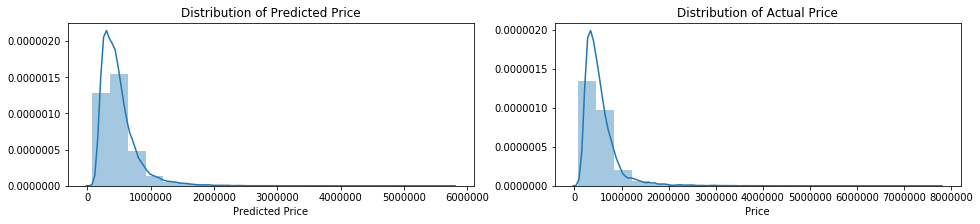

In [79]:
xmin = min(min(df_scaled3['predicted_price_lasso_unlogged']), min(df_scaled3['price']))
xmax = max(max(df_scaled3['predicted_price_lasso_unlogged']), max(df_scaled3['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled3['predicted_price_lasso_unlogged'])),3))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled3['predicted_price_lasso_unlogged'])),3))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
sns.distplot(df_scaled3['predicted_price_lasso_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled3['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

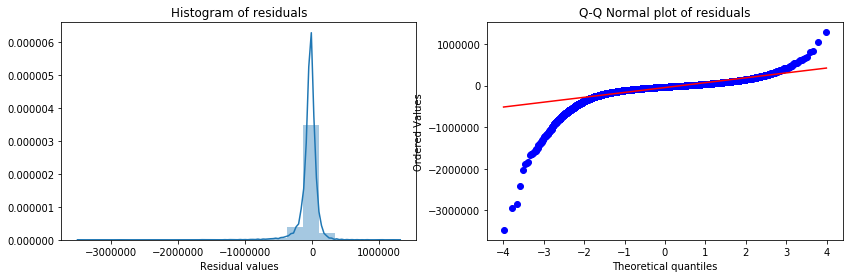

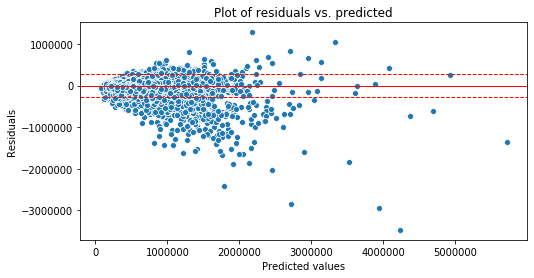

In [80]:
plot_resid_dist(df_scaled3['resids_lasso'])

residual_plot(df_scaled3, 'predicted_price_lasso_unlogged', 'resids_lasso')

In [81]:
ssr3 = sum((df_scaled3['price_log']-df_scaled3['predicted_price_lasso'])**2)       
sst3 = sum((df_scaled3['price_log']-np.mean(df_scaled3['price_log']))**2)    

r_squared3 = 1 - (float(ssr3))/sst3
adjusted_r_squared3 = 1 - (1-r_squared3)*(len(df_scaled3['price_log'])-1)/(len(df_scaled3['price_log'])-df_scaled3[collist2].shape[1]-1)

rmse3 = round(np.sqrt(mean_squared_error(df_scaled3['price'], df_scaled3['predicted_price_lasso_unlogged'])),2)

print('R-Squared: ', np.round(r_squared3,3))
print('Adj R-Squared: ', np.round(adjusted_r_squared3,3))
print('RMSE: ', rmse3)

R-Squared:  0.859
Adj R-Squared:  0.858
RMSE:  147863.07


In [82]:
#elastic net regression

df_scaled4 = df_scaled.copy(deep=True)

y4, X4 = dmatrices(form2, data=df_scaled4)

for j in ['zipcode']:
    df_ohe = pd.get_dummies(df_scaled4[j], prefix=j, columns=[j])
    df_scaled4 = pd.concat([df_ohe, df_scaled4], axis=1)
    df_scaled4.drop(columns = [j], inplace=True)
        
ols_model_elastic = sm.OLS(y4, X4).fit_regularized(method = 'elastic_net', alpha=0.001, L1_wt=0.5)

In [83]:
#df_scaled4 = df_scaled.copy(deep=True)

#ols_model_elastic = smf.ols(form2, data=df_scaled4).fit_regularized(alpha=0.001, L1_wt=0.5)

df_scaled4['predicted_price_elastic'] = ols_model_elastic.predict(df_scaled4.drop(['price_log'], axis=1))

print(df_scaled4[['price_log', 'predicted_price_elastic']])

       price_log  predicted_price_elastic
0      12.309982                11.771372
1      13.195614                12.876689
2      12.100712                12.009034
3      13.311329                12.621933
4      13.142166                12.719841
...          ...                      ...
21608  12.793859                12.844327
21609  12.899220                12.365189
21610  12.904459                12.160897
21611  12.899220                12.410548
21612  12.691580                12.125744

[21611 rows x 2 columns]


In [84]:
df_scaled4['predicted_price_elastic_unlogged'] = np.exp(df_scaled4['predicted_price_elastic'])
df_scaled4['price'] = np.exp(df_scaled4['price_log'])

df_scaled4['resids_elastic'] = np.subtract(df_scaled4['predicted_price_elastic_unlogged'], df_scaled4['price'])

df_scaled4[['price', 'predicted_price_elastic_unlogged', 'resids_elastic']].head()

,price,predicted_price_elastic_unlogged,resids_elastic
0,221900.0,129491.710939,-92408.289061
1,538000.0,391088.375883,-146911.624117
2,180000.0,164231.772231,-15768.227769
3,604000.0,303134.796466,-300865.203534
4,510000.0,334315.724920,-175684.275080


Mean of predicted values = 338827.0
STD of predicted values = 216424.0



Text(0.5, 0, 'Price')

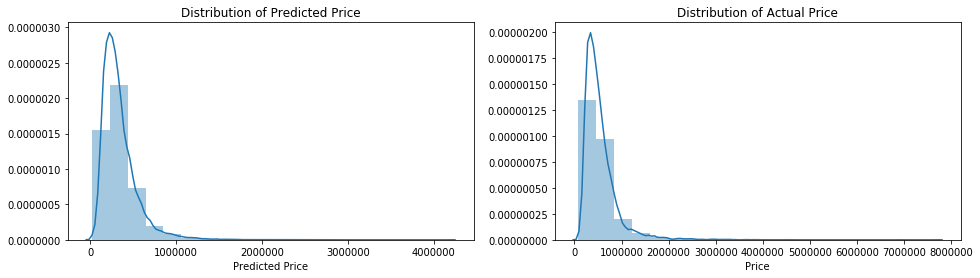

In [85]:
xmin = min(min(df_scaled4['predicted_price_elastic_unlogged']), min(df_scaled4['price']))
xmax = max(max(df_scaled4['predicted_price_elastic_unlogged']), max(df_scaled4['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled4['predicted_price_elastic_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled4['predicted_price_elastic_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled4['predicted_price_elastic_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled4['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

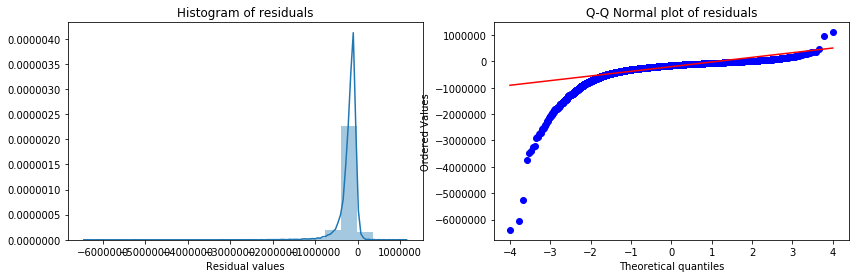

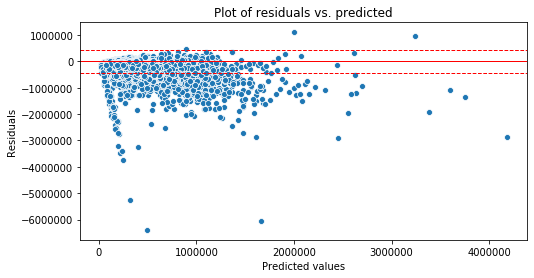

In [86]:
plot_resid_dist(df_scaled4['resids_elastic'])

residual_plot(df_scaled4, 'predicted_price_elastic_unlogged', 'resids_elastic')

In [87]:
ssr4 = sum((df_scaled4['price_log']-df_scaled4['predicted_price_elastic'])**2)       
sst4 = sum((df_scaled4['price_log']-np.mean(df_scaled4['price_log']))**2)    

r_squared4 = 1 - (float(ssr4))/sst4
adjusted_r_squared4 = 1 - (1-r_squared4)*(len(df_scaled4['price_log'])-1)/(len(df_scaled4['price_log'])-df_scaled4[collist2].shape[1]-1)

rmse4 = round(np.sqrt(mean_squared_error(df_scaled4['price'], df_scaled4['predicted_price_elastic_unlogged'])),2)

print('R-Squared: ', np.round(r_squared4,4))
print('Adj R-Squared: ', np.round(adjusted_r_squared4,4))
print('RMSE: ', rmse4)

R-Squared:  -0.1637
Adj R-Squared:  -0.1646
RMSE:  299610.4


In [88]:
df_scaled5 = df_scaled.copy(deep=True)

X5 = df_scaled5.drop(['price_log', 'zipcode'], axis=1)

y5 = df_scaled5['price_log']

print('Head of label matrix \n{}\n'.format(y5[:3]))
print('Design matrix \n{}'.format(X5[:3]))

Head of label matrix 
0    12.309982
1    13.195614
2    12.100712
Name: price_log, dtype: float64

Design matrix 
   bedrooms  bathrooms    floors  waterfront      view  condition     grade  \
0 -0.407191  -1.447417 -0.915420   -0.087177 -0.305775  -0.629167 -0.558870   
1 -0.407191   0.175636  0.936501   -0.087177 -0.305775  -0.629167 -0.558870   
2 -1.510339  -1.447417 -0.915420   -0.087177 -0.305775  -0.629167 -1.409594   

   yr_built  yr_renovated       lat      long  basement  sqft_living_log  \
0 -0.545043     -0.210018 -0.352521 -0.306165 -0.804007        -1.122992   
1 -0.681230      4.749171  1.161579 -0.746426  1.243771         0.709363   
2 -1.294071     -0.210018  1.283544 -0.135742 -0.804007        -2.127877   

   sqft_lot_log  sqft_above_log  sqft_living15_log  sqft_lot15_log  
0     -0.388482       -0.752092          -1.035225       -0.395567  
1     -0.113403        0.672563          -0.326665       -0.024606  
2      0.244170       -1.750356           1.126439      

In [89]:
#perform svd -- svd(A) = U . s . Vt

U, s, Vt = np.linalg.svd(X5, full_matrices=False)

print('For matrix X: \n{}\n'.format(np.round(X5,3)[:3]))
print('U: \n{}\n'.format(np.round(U,3)[:3]))
print('s: \n{}\n'.format(np.round(s,3)))
print('Vt: \n{}'.format(np.round(Vt,3)[:3]))

For matrix X: 
   bedrooms  bathrooms  floors  waterfront   view  condition  grade  yr_built  \
0    -0.407     -1.447  -0.915      -0.087 -0.306     -0.629 -0.559    -0.545   
1    -0.407      0.176   0.937      -0.087 -0.306     -0.629 -0.559    -0.681   
2    -1.510     -1.447  -0.915      -0.087 -0.306     -0.629 -1.410    -1.294   

   yr_renovated    lat   long  basement  sqft_living_log  sqft_lot_log  \
0        -0.210 -0.353 -0.306    -0.804           -1.123        -0.388   
1         4.749  1.162 -0.746     1.244            0.709        -0.113   
2        -0.210  1.284 -0.136    -0.804           -2.128         0.244   

   sqft_above_log  sqft_living15_log  sqft_lot15_log  
0          -0.752             -1.035          -0.396  
1           0.673             -0.327          -0.025  
2          -1.750              1.126           0.042  

U: 
[[-0.007  0.     0.004 -0.002  0.001  0.     0.001 -0.005 -0.004  0.004
   0.005  0.004  0.005 -0.005  0.    -0.001  0.001]
 [ 0.     0.00

In [90]:
#create a diagonal single value matrix
S = np.diag(s)

#matrix multiply:  U * S * Vt
X_reconstructed = np.dot(U, np.dot(S, Vt))

#print('X_reconstructed: \n{}'.format(X_reconstructed))
print('X and X_reconstructed are identical: {}'.format(np.allclose(X5, X_reconstructed)))

X and X_reconstructed are identical: True


In [91]:
print('Singular Values: ', np.round(s))
print('Count of Singular Values: ', len(s))

Singular Values:  [336. 223. 203. 168. 150. 143. 139. 119. 117. 106.  95.  85.  74.  72.
  64.  41.  23.]
Count of Singular Values:  17


Text(0.5, 0, 'Singular value number')

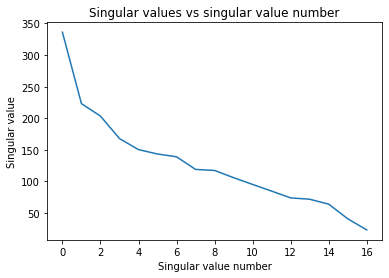

In [101]:
plt.plot(s)
plt.title('Singular values vs singular value number')
plt.ylabel('Singular value')
plt.xlabel('Singular value number')

In [102]:
#calculate D_dagger or the inverse of s with cut off

def set_d(s, cutoff=0.05):
    d = []
    
    for sv in s:
        if(sv > cutoff * s[0]): 
            d.append(1.0/sv)
        else: 
            d.append(0.0)
    
    return d


D_dagger = np.diag(set_d(s))
np.round(D_dagger,4)

array([[0.003 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.0045, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.0049, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.    , 0.006 , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.0066, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.007 , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.    , 0.

In [103]:
non_zero = np.nonzero(set_d(s))
n_elements = len(non_zero[0])
print(n_elements)

17


In [104]:
#create D_dagger_reduced matrix

D_dagger_reduced = D_dagger[:n_elements, :n_elements]
print('Shape: ', D_dagger_reduced.shape)
print(np.round(D_dagger_reduced,3), '\n')


#create U_reduced matrix

U_reduced = U[:,:n_elements]
print('Shape: ', U_reduced.shape)
print(np.round(U_reduced,3), '\n')


#create Vt_reduced matrix

Vt_reduced = Vt[:n_elements,:]
print('Shape: ', Vt_reduced.shape)
print(np.round(Vt_reduced,3), '\n')

Shape:  (17, 17)
[[0.003 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.004 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.005 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.006 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.007 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.007 0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.007 0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.008 0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.009 0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0. 

In [105]:
#calculate the pseudo inverse and matrix coefficients using the reduced dimension
#formula: A_dagger = V . D_dagger . U_transpose

MP_inverse = np.dot(np.transpose(Vt_reduced), np.dot(D_dagger_reduced, np.transpose(U_reduced)))

print('MP inverse matrix: \n', MP_inverse, '\n')
print('MP inverse shape:', MP_inverse.shape, '\n')


b = np.dot(MP_inverse, df_scaled3['price_log'])
print('Model Coefficients: \n', np.round(b,4))

MP inverse matrix: 
 [[ 3.46542090e-05 -7.01546636e-05 -3.21072618e-06 ... -1.10617018e-05
  -1.24618000e-05 -1.25356780e-05]
 [-6.88333229e-05 -7.61794343e-05  6.78192221e-05 ... -2.01805059e-04
   4.21666392e-05 -2.04074601e-04]
 [-6.26217599e-05  5.15281636e-05  2.76412753e-05 ...  5.66303160e-05
  -1.46012871e-05  4.52654426e-05]
 ...
 [ 3.16140032e-05  4.67174471e-04 -1.12387070e-04 ... -9.66436421e-05
  -9.21742145e-05 -9.34598861e-05]
 [-4.46490143e-05 -3.57491691e-05  3.22126173e-04 ... -1.00175780e-04
  -7.13874419e-05 -9.11382191e-05]
 [-8.10410835e-06  5.24845036e-05 -1.00966257e-04 ...  4.13759406e-05
  -3.04673708e-04 -3.81819902e-05]] 

MP inverse shape: (17, 21611) 

Model Coefficients: 
 [-0.0229  0.0507  0.0226  0.035   0.0479  0.0425  0.1929 -0.1041  0.0141
  0.1847  0.0009  0.0363  0.0735  0.0171  0.0727  0.0744 -0.0354]


In [106]:
df_scaled5.loc[:,'predicted_price_svd'] = np.dot(X5, b)

print(df_scaled5.head(2))

   bedrooms  bathrooms    floors  waterfront      view  condition    grade  \
0 -0.407191  -1.447417 -0.915420   -0.087177 -0.305775  -0.629167 -0.55887   
1 -0.407191   0.175636  0.936501   -0.087177 -0.305775  -0.629167 -0.55887   

   yr_built  yr_renovated zipcode  ...  price_log  sqft_living_log  \
0 -0.545043     -0.210018   98178  ...  12.309982        -1.122992   
1 -0.681230      4.749171   98125  ...  13.195614         0.709363   

   sqft_lot_log  sqft_above_log  sqft_living15_log  sqft_lot15_log  \
0     -0.388482       -0.752092          -1.035225       -0.395567   
1     -0.113403        0.672563          -0.326665       -0.024606   

   predicted_price_svd  predicted_price_svd_unlogged     price     resids_svd  
0            -0.484520                      0.576456  221900.0 -221899.423544  
1             0.359937                      1.618628  538000.0 -537998.381372  

[2 rows x 23 columns]


In [107]:
df_scaled5['predicted_price_svd_unlogged'] = np.exp(df_scaled5['predicted_price_svd'])

df_scaled5['price'] = np.exp(df_scaled5['price_log'])

df_scaled5['resids_svd'] = np.subtract(df_scaled5['predicted_price_svd_unlogged'], df_scaled5['price'])

df_scaled5[['price', 'predicted_price_svd_unlogged', 'resids_svd']].head()

,price,predicted_price_svd_unlogged,resids_svd
0,221900.0,0.615993,-221899.384007
1,538000.0,1.433239,-537998.566761
2,180000.0,0.791914,-179999.208086
3,604000.0,0.884843,-603999.115157
4,510000.0,0.957520,-509999.042480


Mean of predicted values = 1.0
STD of predicted values = 1.0



Text(0.5, 0, 'Price')

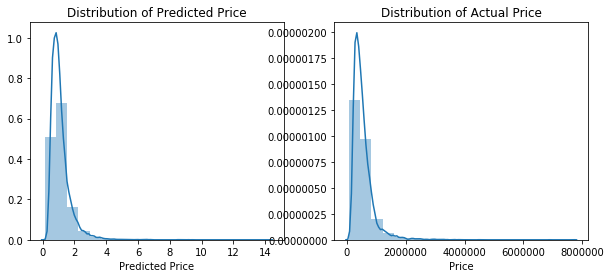

In [108]:
xmin = min(min(df_scaled5['predicted_price_svd_unlogged']), min(df_scaled5['price']))
xmax = max(max(df_scaled5['predicted_price_svd_unlogged']), max(df_scaled5['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled5['predicted_price_svd_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled5['predicted_price_svd_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.distplot(df_scaled5['predicted_price_svd_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled5['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

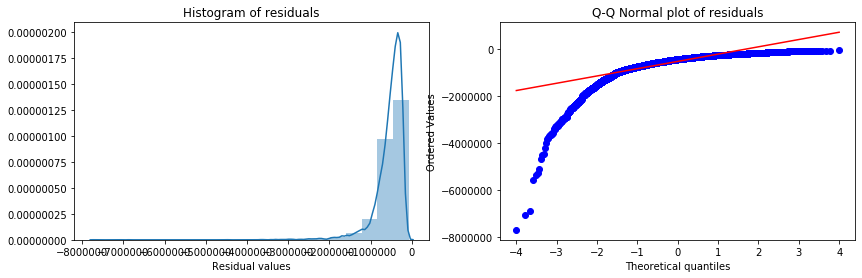

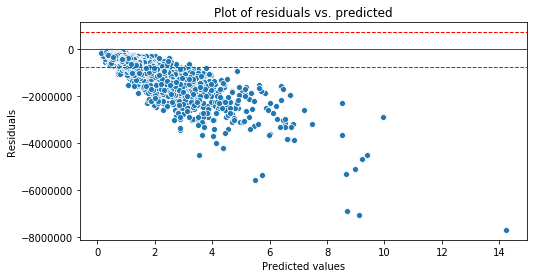

In [109]:
df_scaled5.loc[:,'resids_svd'] = np.subtract(df_scaled5.loc[:,'predicted_price_svd_unlogged'],df_scaled5.loc[:,'price'])

plot_resid_dist(df_scaled5.loc[:,'resids_svd'])
residual_plot(df_scaled5, 'predicted_price_svd_unlogged', 'resids_svd')